In [1]:
import json
import os
import numpy as np
from PIL import Image
import random
import torch

from mvdream.camera_utils import get_camera, create_camera_to_world_matrix, normalize_camera

# Prevent kernel crash
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
dataset_dir = "..\\..\\dissertation_template\\data\\ScanNeRF"
data_class = "trex\\trex"
data_mode = "unmasked_bck"

data_root = os.path.join(os.pardir, dataset_dir, data_class, data_mode)

train_transform_file = os.path.join(data_root, "transforms_train.json")
val_transforms_file = os.path.join(data_root, "transforms_eval.json")


In [3]:
def load_from_json(path):
    with open(path) as f:
        return json.load(f)

def load_dataset(rootdir, split):
    transforms = load_from_json(os.path.join(rootdir, f"transforms_{split}.json"))
        
    # Initialize a list to store the loaded images
    loaded_transforms = []

    # Iterate through the poses
    for frame in transforms["frames"]:
        img_path = os.path.join(data_root, frame["file_path"])
        img_path = img_path.replace("/", "\\") + ".png"
        
        # Open the image using PIL (Pillow)
        img = np.array(Image.open(img_path))
        
        frame["img"] = img
        frame["camera_to_world"] = np.array(frame["transform_matrix"]).astype(np.float32)
        
        # Align input camera poses with unit sphere.
        frame["camera_to_world"] = normalize_camera(frame['camera_to_world']).reshape(4,4)
        
        loaded_transforms.append(frame)
    
    return loaded_transforms
    

In [4]:
train_ds = load_dataset(data_root, "train")
val_ds = load_dataset(data_root, "val")

In [5]:
def getRandomPoses(ds, n=3):
    return random.sample(ds, n)

sample_n = 16

train_sampled_frames = getRandomPoses(train_ds, min(sample_n, len(train_ds)-1))
val_sampled_frames = getRandomPoses(val_ds, min(sample_n, len(val_ds)-1))

In [6]:
azimuth_start = 0
azimuth_span = 360
angle_gap = 30
elevation = 0

azimuths = [azimuth for azimuth in np.arange(azimuth_start, azimuth_span+azimuth_start, angle_gap)]
sampled_poses = [create_camera_to_world_matrix(elevation, azimuth) for azimuth in azimuths]

In [7]:

# Original Author: https://github.com/demul/extrinsic2pyramid/tree/main
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

class CameraPoseVisualizer:
    def __init__(self, xlim, ylim, zlim):
        self.fig = plt.figure(figsize=(18, 7))
        self.ax = self.fig.add_subplot(projection='3d')
        self.ax.set_aspect("auto")
        self.ax.set_xlim(xlim)
        self.ax.set_ylim(ylim)
        self.ax.set_zlim(zlim)
        self.ax.set_xlabel('x')
        self.ax.set_ylabel('y')
        self.ax.set_zlabel('z')
        print('initialize camera pose visualizer')

    def extrinsic2pyramid(self, extrinsic, color='r', focal_len_scaled=5, aspect_ratio=0.3):
        vertex_std = np.array([[0, 0, 0, 1],
                               [focal_len_scaled * aspect_ratio, -focal_len_scaled * aspect_ratio, focal_len_scaled, 1],
                               [focal_len_scaled * aspect_ratio, focal_len_scaled * aspect_ratio, focal_len_scaled, 1],
                               [-focal_len_scaled * aspect_ratio, focal_len_scaled * aspect_ratio, focal_len_scaled, 1],
                               [-focal_len_scaled * aspect_ratio, -focal_len_scaled * aspect_ratio, focal_len_scaled, 1]])
        vertex_transformed = vertex_std @ extrinsic.T
        meshes = [[vertex_transformed[0, :-1], vertex_transformed[1][:-1], vertex_transformed[2, :-1]],
                            [vertex_transformed[0, :-1], vertex_transformed[2, :-1], vertex_transformed[3, :-1]],
                            [vertex_transformed[0, :-1], vertex_transformed[3, :-1], vertex_transformed[4, :-1]],
                            [vertex_transformed[0, :-1], vertex_transformed[4, :-1], vertex_transformed[1, :-1]],
                            [vertex_transformed[1, :-1], vertex_transformed[2, :-1], vertex_transformed[3, :-1], vertex_transformed[4, :-1]]]
        self.ax.add_collection3d(
            Poly3DCollection(meshes, facecolors=color, linewidths=0.3, edgecolors=color, alpha=0.35))

    def customize_legend(self, list_label):
        list_handle = []
        for idx, label in enumerate(list_label):
            color = plt.cm.rainbow(idx / len(list_label))
            patch = Patch(color=color, label=label)
            list_handle.append(patch)
        plt.legend(loc='right', bbox_to_anchor=(1.8, 0.5), handles=list_handle)

    def colorbar(self, max_frame_length):
        cmap = mpl.cm.rainbow
        norm = mpl.colors.Normalize(vmin=0, vmax=max_frame_length)
        self.fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), orientation='vertical', label='Frame Number')

    def show(self):
        plt.title('Extrinsic Parameters')
        plt.show()

In [8]:
%matplotlib widget

In [9]:
# Visualize sampled camera angles in a 3D scene

#visualizer = CameraPoseVisualizer([-10, 10], [-10, 10], [-5, 5])

# argument : extrinsic matrix, color, scaled focal length(z-axis length of frame body of camera
#for frame in train_sampled_frames:
#    pose = frame['camera_to_world']
#    visualizer.extrinsic2pyramid(pose, 'c', 1)

#for frame in val_sampled_frames:
#    pose = frame['camera_to_world']
#    visualizer.extrinsic2pyramid(pose, 'g', 1)
    
#for pose in sampled_poses:
#    visualizer.extrinsic2pyramid(pose, 'r', 1)

#visualizer.show()

In [10]:
train_ds[0]['img'].shape

(1080, 1440, 4)

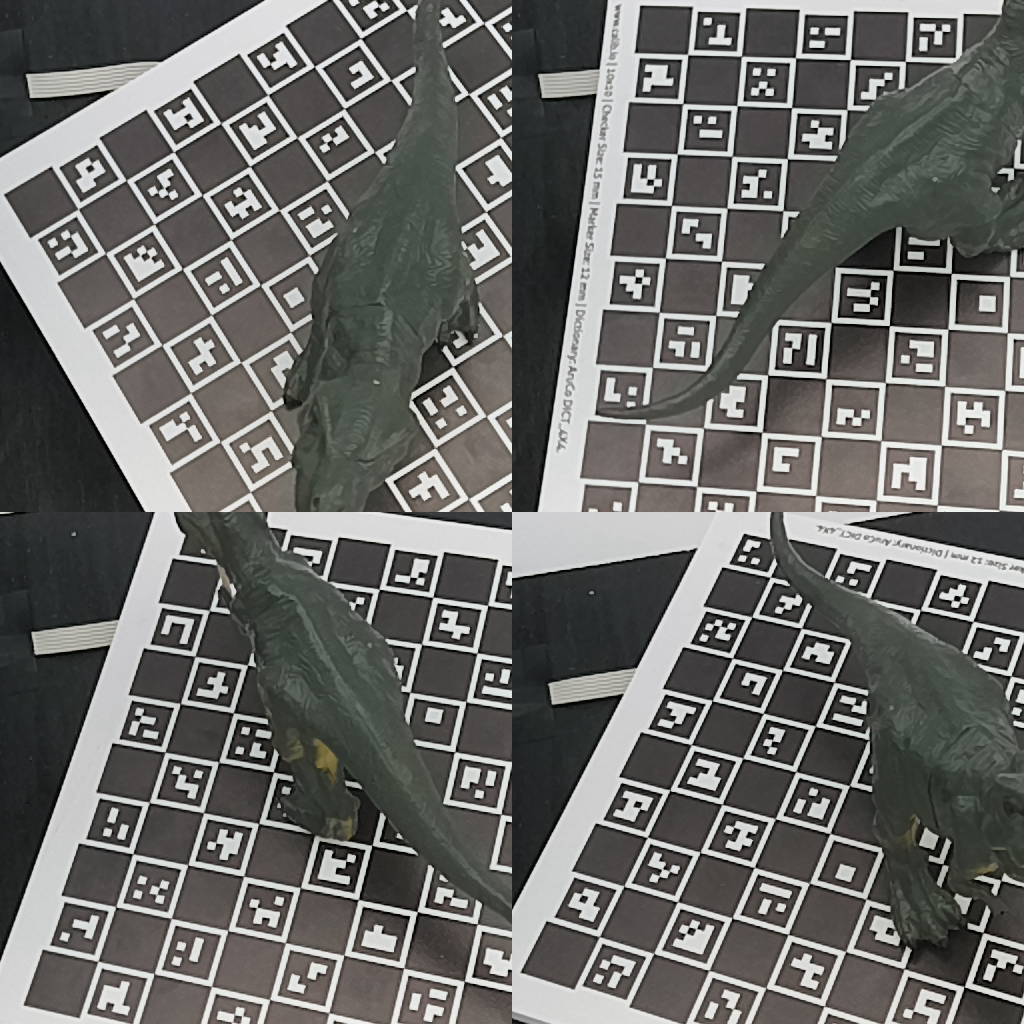

In [11]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

def crop_center(img, w = 512, h = 512):


    # Get the current size of the image
    current_width, current_height = img.size

    # Calculate the coordinates for cropping
    left = (current_width - w) // 2
    top = (current_height - h) // 2
    right = (current_width + w) // 2
    bottom = (current_height + h) // 2

    cropped_image = img.crop((left, top, right, bottom))

    return cropped_image


imgs = [crop_center(Image.fromarray(train_ds[k]['img'])) for k in range(4)]

grid = image_grid(imgs, 2, 2)
grid

In [12]:
x0_imgs = []

x0_imgs = [np.array(crop_center(Image.fromarray(train_ds[k]['img']))).astype(np.float32)[:, :, :3] for k in range(4)]  #

x0_img = np.stack(x0_imgs, axis=0)

for idx, img in enumerate(x0_imgs):
    Image.fromarray(img.astype(np.uint8)).save(f"TestReshape{idx}.png")

x0_img = x0_img.transpose(0, 3, 1, 2)

x0_img = torch.from_numpy(x0_img).to("cuda")

In [13]:
class Args():
    model_name='sd-v2.1-base-4view'
    config_path=None
    ckpt_path=None
    text='a toy dinosaur trex'
    suffix=', 3d asset'
    size=256
    num_frames=4
    use_camera=1
    camera_elev=15
    camera_azim=90
    camera_azim_span=360
    seed=23
    fp16=False
    device='cuda'

In [14]:
import argparse
from mvdream.model_zoo import build_model
from omegaconf import OmegaConf
from mvdream.ldm.util import instantiate_from_config
from mvdream.ldm.models.diffusion.ddim import DDIMSampler

parser = argparse.ArgumentParser()
parser.add_argument("--model_name", type=str, default="sd-v2.1-base-4view", help="load pre-trained model from hugginface")
parser.add_argument("--config_path", type=str, default=None, help="load model from local config (override model_name)")
parser.add_argument("--ckpt_path", type=str, default=None, help="path to local checkpoint")
parser.add_argument("--text", type=str, default="a toy dinosaur trex")#"an astronaut riding a horse")
parser.add_argument("--suffix", type=str, default=", 3d asset")
parser.add_argument("--size", type=int, default=256)
parser.add_argument("--num_frames", type=int, default=4, help="num of frames (views) to generate")
parser.add_argument("--use_camera", type=int, default=1)
parser.add_argument("--camera_elev", type=int, default=15)
parser.add_argument("--camera_azim", type=int, default=90)
parser.add_argument("--camera_azim_span", type=int, default=360)
parser.add_argument("--seed", type=int, default=23)
parser.add_argument("--fp16", action="store_true")
parser.add_argument("--device", type=str, default='cuda')
#args = parser.parse_args()
args = Args()

dtype = torch.float32 if args.fp16 else torch.float16
device = args.device
batch_size = max(4, args.num_frames)

print("load t2i model ... ")
if args.config_path is None:
    model = build_model(args.model_name, ckpt_path=args.ckpt_path)
else:
    assert args.ckpt_path is not None, "ckpt_path must be specified!"
    config = OmegaConf.load(args.config_path)
    model = instantiate_from_config(config.model)
    model.load_state_dict(torch.load(args.ckpt_path, map_location='cpu'))
model.device = device
model.to(device)
model.eval()

sampler = DDIMSampler(model)
uc = model.get_learned_conditioning( [""] ).to(device)
print("load t2i model done . ")

A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'


load t2i model ... 
Loading model from config: sd-v2-base.yaml
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 5 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 1024 and using 5 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 5 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 1024 and using 5 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 10 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 1024 and using 10 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 10 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 1024 and using 10 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_dim is None and using 20 heads.
Setting up MemoryEfficientCrossAttention

In [15]:
x0_img.shape

torch.Size([4, 3, 512, 512])

In [16]:
with torch.no_grad(), torch.autocast(device_type=device, dtype=dtype):
    
  x0 = model.first_stage_model.encode(x0_img)
    #x_sample = model.first_stage_model.decode(x0.sample())

    #print(x_sample.shape)
    #x_sample = x_sample.permute(0,2,3,1).cpu().numpy()
        
    #images = list(x_sample.astype(np.uint8))

    #images = np.concatenate(images, 1)
    #Image.fromarray(images).save(f"EncodeDecode.png")
   # print(model.scale_factor) #0.18215
    #x0.shape

    #model.scale_factor = 1
  x0 = model.get_first_stage_encoding(x0)

  x_sample = model.decode_first_stage(x0)

   # def get_first_stage_encoding(self, encoder_posterior):
   #     if isinstance(encoder_posterior, DiagonalGaussianDistribution):
   #         z = encoder_posterior.sample()
  #      elif isinstance(encoder_posterior, torch.Tensor):
   #         z = encoder_posterior
   #     else:
   #         raise NotImplementedError(f"encoder_posterior of type '{type(encoder_posterior)}' not yet implemented")
   #     return self.scale_factor * z

   # def encode_first_stage(self, x):
   #     return self.first_stage_model.encode(x)
    
  #  def decode_first_stage(self, z):
  #      z = 1. / self.scale_factor * z
  #      return self.first_stage_model.decode(z)



  x_sample = torch.clamp((x_sample + 1.0) / 2.0, min=0.0, max=1.0)
  x_sample = 255. * x_sample.permute(0,2,3,1).cpu().numpy()
        
  images = list(x_sample.astype(np.uint8))

  images = np.concatenate(images, 1)
  Image.fromarray(images).save(f"EncodeDecode.png")

In [17]:
import gc
torch.cuda.empty_cache()
gc.collect()

34

In [18]:
#Image.fromarray(list(255. * x0_img.permute(0,2,3,1).cpu().numpy().astype(np.uint8)))

z = np.concatenate(x0_img.permute(0,2,3,1).cpu().numpy().astype(np.uint8), 1)
z.shape

Image.fromarray(z).save(f"og.png")

In [19]:
def x0_img_to_latents(init_image):
    '''     
    Function to convert image to latents     
    '''     
    #init_image = init_image.unsqueeze(0) * 2.0 - 1.0
    print(init_image.shape)
    #init_image = #init_image.to(device="cuda", dtype=torch.float16)
    init_latent_dist = model.first_stage_model.encode(init_image).sample() * 0.18215        #vae.encode(init_image).latent_dist.sample() * 0.18215     
    return init_latent_dist  

In [20]:
with torch.no_grad(), torch.autocast(device_type=device, dtype=dtype):
    latent_img = x0_img_to_latents(x0_img)
#print(f"Dimension of this latent representation: {latent_img.shape}")
x0_img.shape

torch.Size([4, 3, 512, 512])


torch.Size([4, 3, 512, 512])

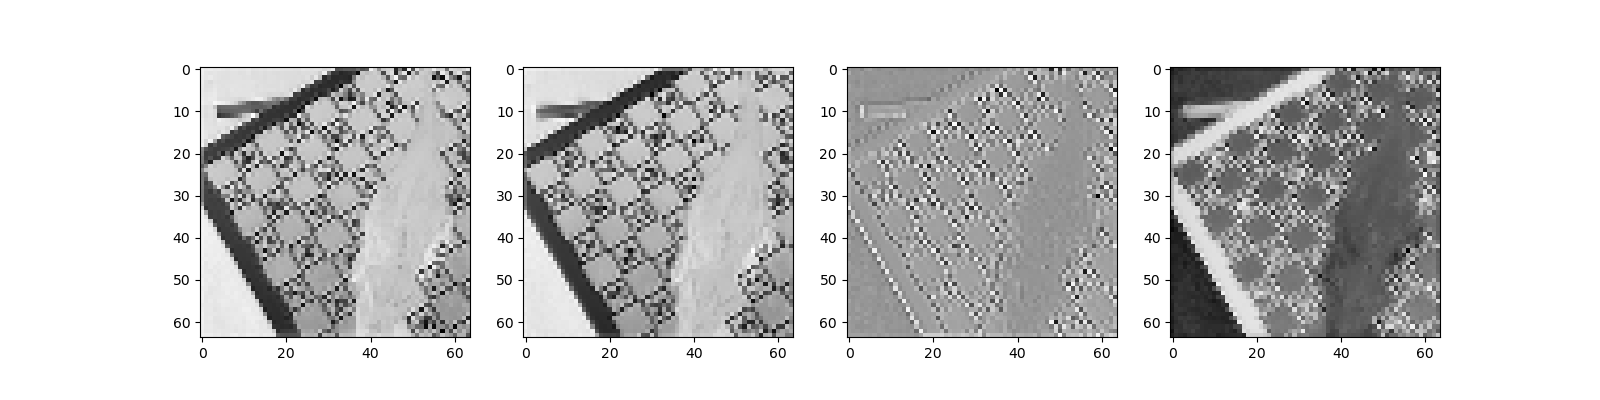

In [21]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for c in range(4):
    axs[c].imshow(latent_img[0][c].detach().cpu(), cmap='Greys')

In [22]:
latent_img.shape

torch.Size([4, 4, 64, 64])

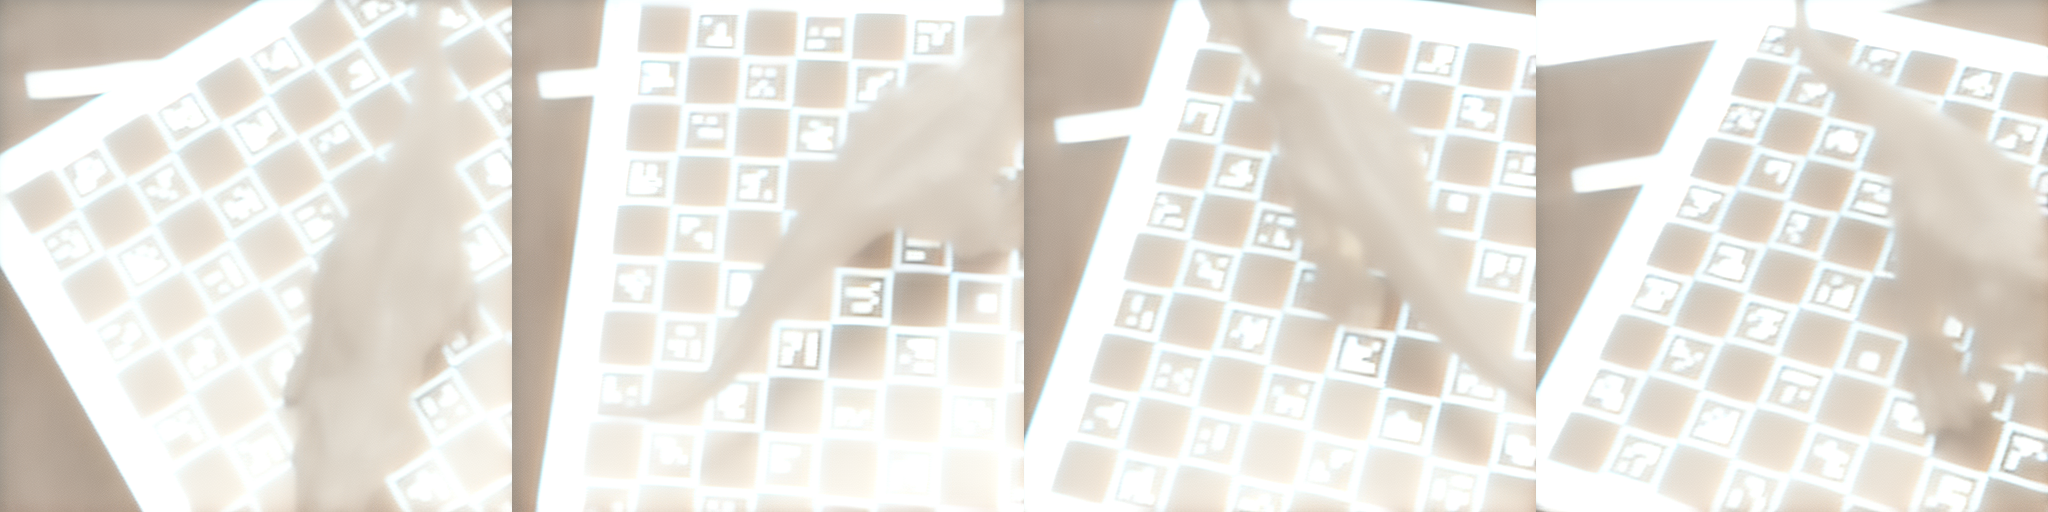

In [23]:
def x0_latents_to_pil(latents):     
    '''     
    Function to convert latents to images     
    '''     
    latents = (1 / 0.18215) * latents     
    with torch.no_grad():         
        image =   model.first_stage_model.decode(latents)#.sample #vae.decode(latents).sample     
    
    image = (image / 2 + 0.5).clamp(0, 1)     
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()      
    images = (image * 255).round().astype("uint8")     
    pil_images = [Image.fromarray(image) for image in images]        
    return pil_images

with torch.no_grad(), torch.autocast(device_type=device, dtype=dtype):
    decoded_img = x0_latents_to_pil(latent_img)
    decoded_img[0]

decoded_img = np.concatenate(decoded_img, 1)
decoded_img
Image.fromarray(decoded_img)#.save(f"EncodeDecode.png")

In [24]:
## To import an image from a URL 
from fastdownload import FastDownload  

import torch, logging
## Imaging  library 
from PIL import Image 
from torchvision import transforms as tfms  
## Basic libraries 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline  
## Loading a VAE model 
from diffusers import AutoencoderKL 
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", torch_dtype=torch.float32).to("cuda")
def load_image(p):    
    return Image.open(p).convert('RGB').resize((512,512))
def pil_to_latents(image):
    '''     
    Function to convert image to latents     
    '''     
    init_image = tfms.ToTensor()(image).unsqueeze(0) * 2.0 - 1.0
    print(init_image.shape)
    init_image = init_image.to(device="cuda", dtype=torch.float32)
    init_latent_dist = vae.encode(init_image).latent_dist.sample() * 0.18215     
    return init_latent_dist  
def latents_to_pil(latents):     
    '''     
    Function to convert latents to images     
    '''     
    latents = (1 / 0.18215) * latents     
    with torch.no_grad():         
        image =  vae.decode(latents).sample     
    
    image = (image / 2 + 0.5).clamp(0, 1)     
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()      
    images = (image * 255).round().astype("uint8")     
    pil_images = [Image.fromarray(image) for image in images]        
    return pil_images

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Dimension of this image: (512, 512, 3)


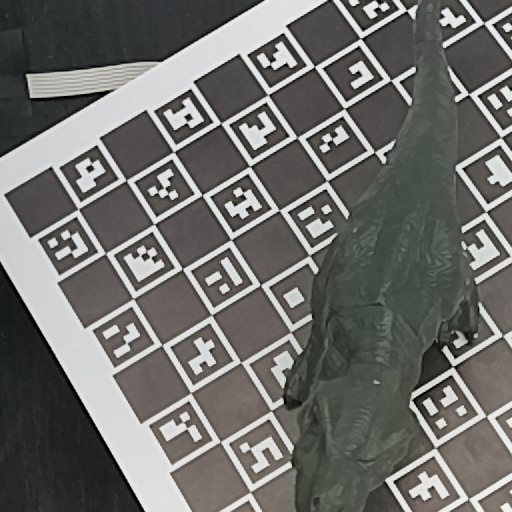

In [25]:
p = FastDownload().download('https://lafeber.com/pet-birds/wp-content/uploads/2018/06/Scarlet-Macaw-2.jpg')
img = load_image(p)
print(f"Dimension of this image: {np.array(img).shape}")
img
img = crop_center(Image.fromarray(train_ds[0]['img'][:,:,:3]))
img


In [38]:
import gc
torch.cuda.empty_cache()
gc.collect()

latent_img_base = pil_to_latents(img)
print(f"Dimension of this latent representation: {latent_img_base.shape}")
img

#Image.fromarray(img)

torch.Size([1, 3, 512, 512])


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacty of 12.00 GiB of which 0 bytes is free. Of the allocated memory 11.09 GiB is allocated by PyTorch, and 171.21 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

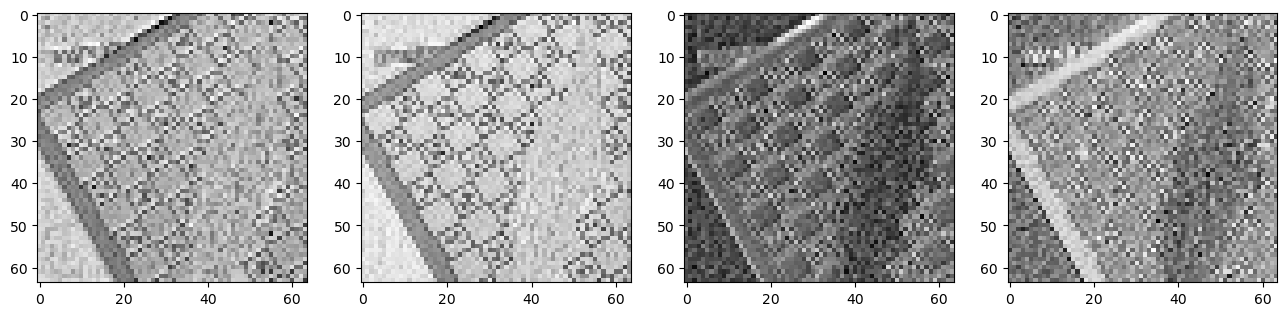

In [29]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for c in range(4):
    axs[c].imshow(latent_img_base[0][c].detach().cpu(), cmap='Greys')

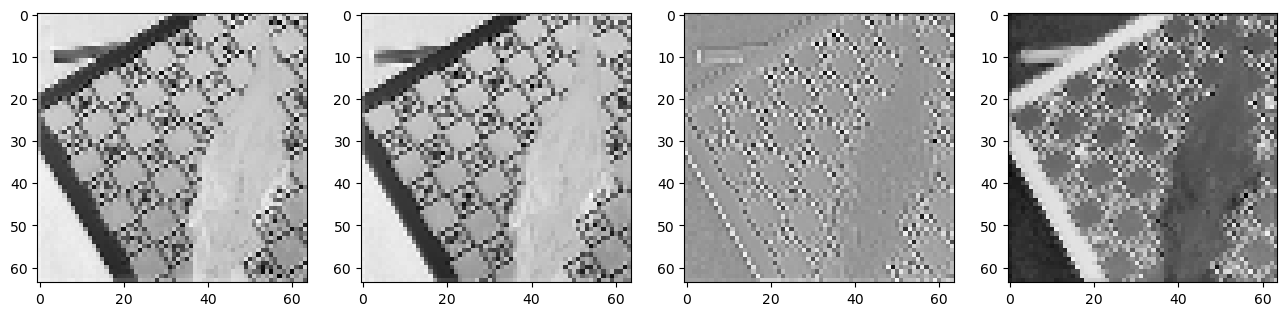

In [30]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for c in range(4):
    axs[c].imshow(latent_img[0][c].detach().cpu(), cmap='Greys')

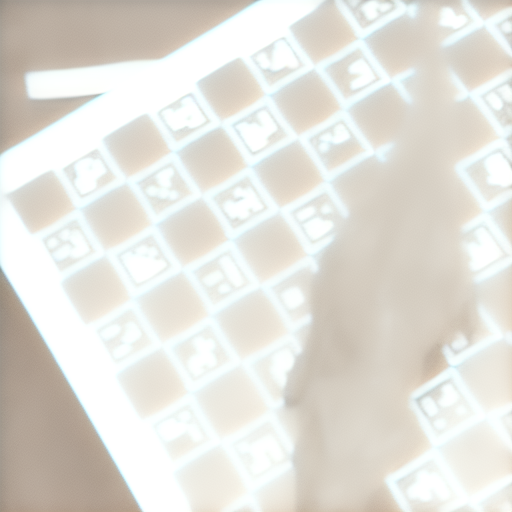

In [34]:
import gc
torch.cuda.empty_cache()
gc.collect()


latent_img[:2,:,:,:].reshape(2, 4, 64, 64).shape
decoded_img = latents_to_pil(latent_img[0,:,:,:].reshape(-1, 4, 64, 64))
decoded_img[0]

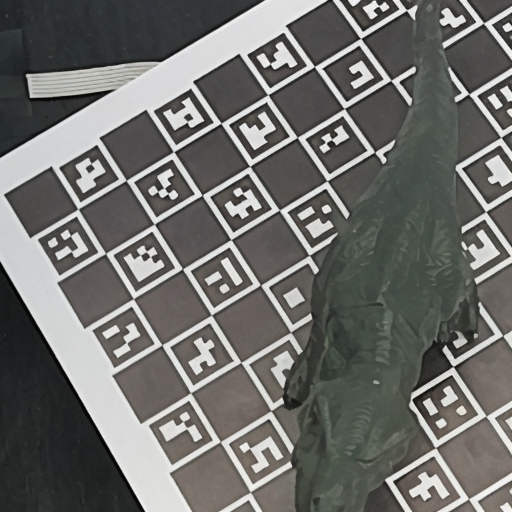

In [37]:
import gc
torch.cuda.empty_cache()
gc.collect()

decoded_img = x0_latents_to_pil(latent_img_base[0,:,:,:].reshape(-1, 4, 64, 64))
decoded_img[0]

#IDENTICAL DECODERS!!!!!
#DIFFERENCE IN ENCODERS!!!

In [35]:
print(latent_img_base)
print(latent_img)

tensor([[[[-0.9574, -0.6492, -0.2252,  ..., -0.3342, -0.8650, -0.8628],
          [-1.0359,  0.2363,  0.6183,  ..., -1.2886,  1.0999,  1.3638],
          [-0.3939, -0.0841, -0.8168,  ...,  1.5688, -0.8924,  0.4085],
          ...,
          [-0.3833, -0.0782, -0.4840,  ..., -0.0074,  0.1453,  0.2584],
          [-0.8671, -0.7684, -0.3904,  ...,  0.6038, -0.9068,  0.5070],
          [-0.9632, -0.8859, -0.8718,  ..., -0.4343, -0.2186,  2.1673]],

         [[-0.8656, -1.6876, -1.1374,  ..., -1.0729, -0.2489, -0.3728],
          [-1.1438, -1.2863, -1.2592,  ..., -1.2101, -0.7779,  1.5373],
          [-0.1519, -1.6522, -1.5351,  ...,  1.6164,  0.9562, -1.2538],
          ...,
          [-0.9290, -1.4900, -0.5904,  ...,  1.3780, -1.2550,  0.6007],
          [-1.2468, -0.6858, -1.6023,  ..., -0.6657,  0.3477, -0.4128],
          [-0.9043, -1.0751, -1.4849,  ..., -0.1375,  1.5384,  0.2258]],

         [[ 0.6654,  1.1247,  0.9155,  ...,  0.7983,  1.3906, -0.1164],
          [-0.2638,  1.5962,  